In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [85]:

# read the data, make a df of 150 instances
df1 = pd.read_excel('results/TABU/output_1000e_200.xlsx')
df2 = pd.read_excel('results/TABU/output_1000e_200_ctd1.xlsx')

df = pd.concat([df1, df2])
df = df[df['instance'] < 151]
df = df.rename(columns={'number of movements': 'movements reached'})

df_instances = pd.read_excel('results/instanceData_200.xlsx')
df = pd.merge(df, df_instances, on='instance')

# only train on the solved instances
df = df[df['solution_found'] == 1]

print(df.columns)
print(len(df))

Index(['instance', 'movements reached', 'median delay', 'average delay',
       'obj_val', 'tabu_list_size', 'number_of_tweaks', 'affected_movements',
       'epochs', 'time_interval', 'vessel_time_window', 'solution_found',
       'number_of_movements', 'number_of_headways', 'number_of_vessels',
       'average_headway', 'std_dev_headway', 'spread',
       'average_time_between_movements', 'average_travel_time'],
      dtype='object')
768


In [86]:
# recalculate the objective function
movements_factor = 0.01
headway_factor = 0.001
df['objective_function'] = df['average delay'] \
                           + df['movements reached'] * movements_factor
print(df['objective_function'], df['average delay'])

6       0.933333
30      0.852281
31      0.470702
33      0.668070
34      0.418070
          ...   
4476    0.651818
4487    1.246515
4494    1.454848
4496    1.420758
4497    0.920758
Name: objective_function, Length: 768, dtype: float64 6       0.733333
30      0.662281
31      0.280702
33      0.478070
34      0.228070
          ...   
4476    0.431818
4487    1.026515
4494    1.234848
4496    1.200758
4497    0.700758
Name: average delay, Length: 768, dtype: float64


In [87]:
feature_cols = ['tabu_list_size','number_of_tweaks', 'affected_movements',
    'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
    'average_time_between_movements', 'average_travel_time']

X = df[feature_cols].values
y = df['objective_function'].values

In [88]:
# define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
model = Net()
# to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [89]:
import tqdm

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 40  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
            if epoch % 10 == 0:
                history.append(float(loss))
                print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = model.state_dict().copy()
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch: 0, Loss: 0.9152
Epoch: 0, Loss: 0.6476
Epoch: 0, Loss: 1.0378
Epoch: 0, Loss: 1.0382
Epoch: 0, Loss: 0.8486
Epoch: 0, Loss: 1.2037
Epoch: 0, Loss: 0.7808
Epoch: 0, Loss: 1.0022
Epoch: 0, Loss: 1.0395
Epoch: 0, Loss: 0.8402
Epoch: 0, Loss: 0.9324
Epoch: 0, Loss: 1.0248
Epoch: 0, Loss: 0.6296
Epoch: 0, Loss: 0.7649
Epoch: 0, Loss: 0.8730
Epoch: 0, Loss: 0.7267
Epoch: 10, Loss: 0.2412
Epoch: 10, Loss: 0.1261
Epoch: 10, Loss: 0.3123
Epoch: 10, Loss: 0.3025
Epoch: 10, Loss: 0.2264
Epoch: 10, Loss: 0.3426
Epoch: 10, Loss: 0.1248
Epoch: 10, Loss: 0.2665
Epoch: 10, Loss: 0.3246
Epoch: 10, Loss: 0.2276
Epoch: 10, Loss: 0.2074
Epoch: 10, Loss: 0.3072
Epoch: 10, Loss: 0.1131
Epoch: 10, Loss: 0.1821
Epoch: 10, Loss: 0.2608
Epoch: 10, Loss: 0.1442
Epoch: 20, Loss: 0.1607
Epoch: 20, Loss: 0.1199
Epoch: 20, Loss: 0.2145
Epoch: 20, Loss: 0.2027
Epoch: 20, Loss: 0.1534
Epoch: 20, Loss: 0.2006
Epoch: 20, Loss: 0.0747
Epoch: 20, Loss: 0.1434
Epoch: 20, Loss: 0.2050
Epoch: 20, Loss: 0.1465
Epoch: 2

<All keys matched successfully>

MSE: 0.12
RMSE: 0.35


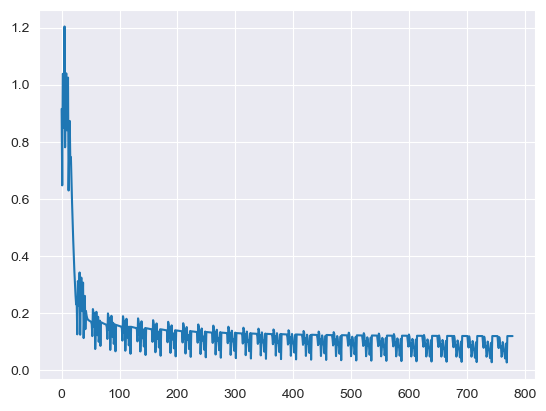

In [90]:
# plot the loss
import matplotlib.pyplot as plt

model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

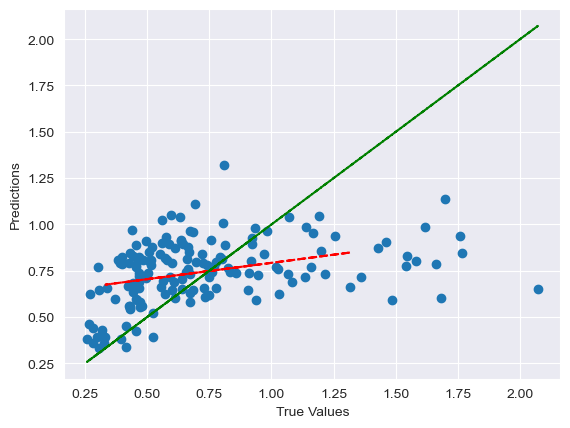

In [91]:
# plot the predictions as a scatter plot
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
# plot the line of best fit
# y_pred to 1D array
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_pred,p(y_pred),"r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()

In [92]:
# get the MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: %.2f" % mape)

# get the MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("MAE: %.2f" % mae)

# get the MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

# get the RMSE
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.2f" % rmse)

# get the R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2: %.2f" % r2)

# get the adjusted R2
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R2: %.2f" % adj_r2)


MAPE: 0.39
MAE: 0.26
MSE: 0.12
RMSE: 0.35
R2: 0.12
Adjusted R2: 0.06


In [52]:
# save the model
torch.save(model.state_dict(), 'results/TABU/models/NN_model_150-best.pth')

# save the scaler
import pickle
with open('results/TABU/models/scaler_150-correct-best.pkl', 'wb') as f:
    pickle.dump(scaler, f)